The code is written by Livia Nathania Fireta and it references the code from workshop written by Jeffrey Chan (2023)

In [1]:
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np
import math

import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from langdetect import detect, DetectorFactory

import matplotlib.pyplot as plt

import sys
import json
import re

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Livia
[nltk_data]     Nathania\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Process Text

In [2]:
DetectorFactory.seed = 0

def processText_lem(text, tokenizer, stemmer, stopwords, language = 'en'):
    """
    Perform tokenisation, normalisation (lower case and lemmatization) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """
    # Detect language and only proceed if the text is in the target language
    try:
        detected_language = detect(text)
    except:
        return []  # Return empty list if language detection fails

    if detected_language != language:
        return []  # Return empty list if the text is not in the target language
        
    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = [stemmer.lemmatize(tok, pos = 'v') for tok in lTokens]
    
    regexHttp = re.compile("^http")
    regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
    regexhash = re.compile(r"^(#|@)")

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    # Remove emojis from each token
    lStemmedTokens = [emoji_pattern.sub(r'', tok) for tok in lStemmedTokens]

    # remove stopwords, digits/urls
    return [tok for tok in lStemmedTokens if tok not in stopwords and 
            not tok.isdigit() and 
            tok and
            regexHttp.match(tok) == None and 
            regexDigit.match(tok) == None and
            regexhash.match(tok) == None]

### Retrieve Reddit and Youtube Post

In [3]:
# load json file
fJsonName_reddit = 'olympics_posts_reddit.json'
fJsonName_youtube = 'NEW_youtube_olympics_data_limited_250_per_hashtag.json'

# number of most frequent terms to display
freqNum = 50

# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)

# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', " ","➡",'via','@','#', '...','..', '…', "sure",'"', "'", '`','.',"’",
                                                                '-',"it'","i'm","i've"]
# we use the lemmatisation approach
tweetStemmer_lem = WordNetLemmatizer()

lPosts = []

with open(fJsonName_youtube, 'r') as f:
    ySubmissions = json.load(f)

with open(fJsonName_reddit, 'r') as f:
    dSubmissions = json.load(f)

for s in [ySubmissions, dSubmissions]:
    if s == dSubmissions: 
        for submission in dSubmissions:
            submissionsTitle = submission['title']
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I) #replace olympic with olympics
            submissionSelftext = submission['selftext']
            submissionSelftext  = re.sub(r"\bolympic\b","olympics",submissionSelftext , flags = re.I) 
            
            # tokenise, filter stopwords and get convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext , 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts.append(' '.join(lTokens))
        
            # process the comments
            for comment in submission['comments']:
                commentText = comment['body']
                commentText  = re.sub(r"\bolympic\b","olympics",commentText, flags = re.I)
                
                lTokens = processText_lem(text=commentText, 
                                          tokenizer=tweetTokeniser, 
                                          stemmer=tweetStemmer_lem, 
                                          stopwords=lStopwords)
                lPosts.append(' '.join(lTokens))
                
    else:
        for submission in ySubmissions:
            submissionDescription = submission['Description']
            submissionDescription  = re.sub(r"\bolympic\b","olympics",submissionDescription , flags = re.I)
            submissionsTitle = submission['Video Title']
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            
            # tokenise, filter stopwords and get convert to lower case
            lTokens = processText_lem(text=submissionDescription + ' ' + submissionsTitle, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts.append(' '.join(lTokens))
            # process the comments
            for comment in submission['Comments']:
                commentText = comment['text']
                commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
                lTokens = processText_lem(text=commentText, 
                                          tokenizer=tweetTokeniser, 
                                          stemmer=tweetStemmer_lem, 
                                          stopwords=lStopwords)
                lPosts.append(' '.join(lTokens))


### LDA model

In [4]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 15
# the number of features/words to used to describe our documents
featureNum = 2000

In [5]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf = tfVectorizer.fit_transform(lPosts)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 999).fit(tf)

### Visualising topics

In [6]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [7]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
olympics people game team much get best use first fuck match women shit ever two
Topic 1:
make sport could many year back one get players money run compete already day yes
Topic 2:
one still come need lot well feel lose work guy proud event pretty usa thank
Topic 3:
go play us way better great every good lol let live re put song enough
Topic 4:
like would think even know really look world see athletes right that last want mean
Topic 5:
win say get gold olympics also medal love give india time go watch medals japan


In [8]:
# pyLDAvis 
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

### WordCloud

In [9]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 2
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    plt.show(block=True)

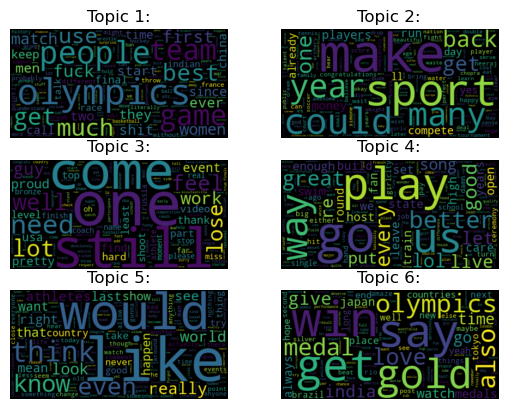

In [10]:
# display wordcloud
displayWordcloud(ldaModel, tfFeatureNames)

### Topic per olympic

In [11]:
import pandas as pd
import codecs
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Livia
[nltk_data]     Nathania\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
import pandas as pd
# import json file 
with open(fJsonName_reddit, 'r') as f:
    dSubmissions = json.load(f)

olympics_post = []
for sub in dSubmissions:
    olympics_post.append({'title': sub['title'],
            'author': sub['author_id'],
            'text' : sub['selftext'],
            'created': sub['created'],
            'olympics':sub['keyword'],
            'type' : "post",
            })

olympics_comment_reddit = []
for sub in dSubmissions:
    for com in sub['comments']:
        olympics_comment_reddit.append({
            'title': sub['title'],
            'author':com['author_id'],
            'text':com['body'],
            'created':com['created'],
            'olympics':sub['keyword'],
            'type':"comment"
        })

reddit_df = pd.DataFrame(olympics_post)
reddit_com_df = pd.DataFrame(olympics_comment_reddit)

In [13]:
with open(fJsonName_youtube, 'r') as f:
    ySubmissions = json.load(f)

olympics_post2 = []
for sub in ySubmissions:
    olympics_post2.append({'title': sub['Video Title'],
            'text' : sub['Description'],
            'olympics':sub['Hashtag']
            })
    
olympics_comment_youtube  = []
for sub in ySubmissions:
    for com in sub['Comments']:
        olympics_comment_youtube.append({
            'author':com['author'],
            'text':com['text'],
            'created':com['published_at'],
            'olympics':sub['Hashtag']
        })

youtube_df = pd.DataFrame(olympics_post2)
youtube_com_df = pd.DataFrame(olympics_comment_youtube) 

In [14]:
reddit_2024 = reddit_df[reddit_df['olympics'] == 'Olympics 2024']
reddit_2020 = reddit_df[reddit_df['olympics'] == 'Olympics 2020']
reddit_2016 = reddit_df[reddit_df['olympics'] == 'Olympics 2016']

reddit_com_2024 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2024']
reddit_com_2020 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2020']
reddit_com_2016 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2016']

In [15]:
youtube_2024 = youtube_df[youtube_df['olympics'] == '#paris2024']
youtube_2020 = youtube_df[youtube_df['olympics'] == '#tokyo2020']
youtube_2016 = youtube_df[youtube_df['olympics'] == '#rio2016']

youtube_com_2024 = youtube_com_df[youtube_com_df['olympics'] == '#paris2024']
youtube_com_2020 = youtube_com_df[youtube_com_df['olympics'] == '#tokyo2020']
youtube_com_2016 = youtube_com_df[youtube_com_df['olympics'] == '#rio2016']

#### For olympics 2024

In [16]:
# Initialize the list to store processed posts and comments
lPosts_2024 = []

# Iterate through 'reddit' and 'youtube' to process both data sources
for s in ['reddit', 'youtube']:
    if s == 'reddit': 
        # Iterate through each row in reddit_2024 DataFrame using itertuples()
        for row in reddit_2024.itertuples(index=True, name='RedditRow'):
            submissionsTitle = row.title
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            submissionSelftext = row.text
            submissionSelftext  = re.sub(r"\bolympic\b","olympics",submissionSelftext , flags = re.I)  
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))
        
        for comment_row in reddit_com_2024.itertuples(index=True, name='RedditCommentRow'):
            commentText = comment_row.text
            commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))
                
    else:  
        for row in youtube_2024.itertuples(index=True, name='YouTubeRow'):
            submissionsTitle = row.title
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            submissionDescription = row.text
            submissionDescription  = re.sub(r"\bolympic\b","olympics",submissionDescription , flags = re.I)
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionDescription, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))
    
        for comment_row in youtube_com_2024.itertuples(index=True, name='YouTubeCommentRow'):
            commentText = comment_row.text
            commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))



In [17]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 12
# the number of features/words to used to describe our documents
featureNum = 1500

In [18]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf_2024 = tfVectorizer.fit_transform(lPosts_2024)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel_2024 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 999).fit(tf_2024)

In [19]:
display_topics(ldaModel_2024, tfFeatureNames, wordNumToDisplay)

Topic 0:
get go olympics athletes know would like even better much great want
Topic 1:
france win gold los team medal india usa amo olympics countries medals
Topic 2:
congratulations que play bed todos song first run big hard lose second
Topic 3:
olympics paris game world beautiful women congrats event break men next top
Topic 4:
make people like love look watch best good open come ceremony never
Topic 5:
one sport olympics well french take world let years worst ever shame


In [20]:
# pyLDAvis 
panel = pyLDAvis.lda_model.prepare(ldaModel_2024, tf_2024, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

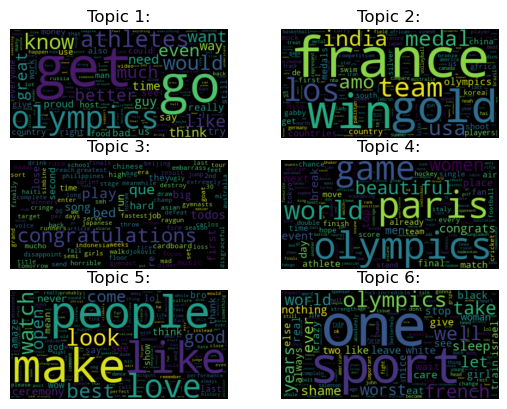

In [21]:
# display wordcloud
displayWordcloud(ldaModel_2024, tfFeatureNames)

#### For olympics 2020

In [22]:
# Initialize the list to store processed posts and comments
lPosts_2020 = []

# Iterate through 'reddit' and 'youtube' to process both data sources
for s in ['reddit', 'youtube']:
    if s == 'reddit': 
        # Iterate through each row in reddit_2024 DataFrame using itertuples()
        for row in reddit_2020.itertuples(index=True, name='RedditRow'):
            submissionsTitle = row.title
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            submissionSelftext = row.text
            submissionSelftext  = re.sub(r"\bolympic\b","olympics",submissionSelftext , flags = re.I)  
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))
        
        for comment_row in reddit_com_2020.itertuples(index=True, name='RedditCommentRow'):
            commentText = comment_row.text
            commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))
                
    else:  
        for row in youtube_2020.itertuples(index=True, name='YouTubeRow'):
            submissionsTitle = row.title
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            submissionDescription = row.text
            submissionDescription  = re.sub(r"\bolympic\b","olympics",submissionDescription , flags = re.I)
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionDescription, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))
    
        for comment_row in youtube_com_2020.itertuples(index=True, name='YouTubeCommentRow'):
            commentText = comment_row.text
            commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))

In [23]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 12
# the number of features/words to used to describe our documents
featureNum = 1500

In [24]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf_2020 = tfVectorizer.fit_transform(lPosts_2020)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel_2020 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 999).fit(tf_2020)

In [25]:
display_topics(ldaModel_2020, tfFeatureNames, wordNumToDisplay)

Topic 0:
love like watch great congratulations look people know get see guy girl
Topic 1:
gold win medal get olympics first time sport best world one well
Topic 2:
go say name remember players happy find way ball im take know
Topic 3:
proud olympics indian thank make video moment amaze still us years ever
Topic 4:
song japan japanese game good like tokyo olympics really show hope sonic
Topic 5:
india team neeraj chopra please women match hockey day men final jai


In [26]:
# pyLDAvis 
panel = pyLDAvis.lda_model.prepare(ldaModel_2020, tf_2020, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

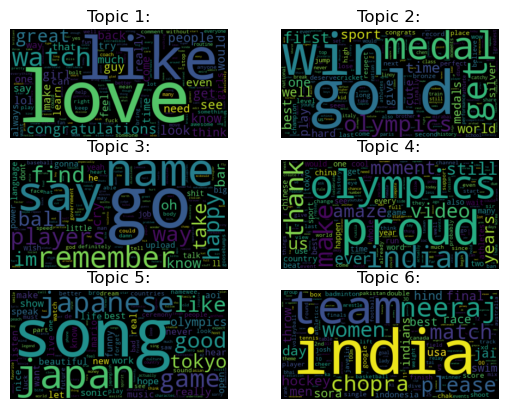

In [27]:
# display wordcloud
displayWordcloud(ldaModel_2020, tfFeatureNames)

#### For olympics 2016

In [28]:
# Initialize the list to store processed posts and comments
lPosts_2016 = []

# Iterate through 'reddit' and 'youtube' to process both data sources
for s in ['reddit', 'youtube']:
    if s == 'reddit': 
        # Iterate through each row in reddit_2024 DataFrame using itertuples()
        for row in reddit_2016.itertuples(index=True, name='RedditRow'):
            submissionsTitle = row.title
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            submissionSelftext = row.text
            submissionSelftext  = re.sub(r"\bolympic\b","olympics",submissionSelftext , flags = re.I)  
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))
        
        for comment_row in reddit_com_2016.itertuples(index=True, name='RedditCommentRow'):
            commentText = comment_row.text
            commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))
                
    else:  
        for row in youtube_2016.itertuples(index=True, name='YouTubeRow'):
            submissionsTitle = row.title
            submissionsTitle  = re.sub(r"\bolympic\b","olympics",submissionsTitle , flags = re.I)
            submissionDescription = row.text
            submissionDescription  = re.sub(r"\bolympic\b","olympics",submissionDescription , flags = re.I)
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionDescription, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))
    
        for comment_row in youtube_com_2016.itertuples(index=True, name='YouTubeCommentRow'):
            commentText = comment_row.text
            commentText  = re.sub(r"\bolympic\b","olympics",commentText , flags = re.I)
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))

In [29]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 12
# the number of features/words to used to describe our documents
featureNum = 1500

In [30]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf_2016 = tfVectorizer.fit_transform(lPosts_2016)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel_2016 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 999).fit(tf_2016)

In [31]:
display_topics(ldaModel_2016, tfFeatureNames, wordNumToDisplay)

Topic 0:
win gold medal team women olympics match lose amaze india men final
Topic 1:
brazil world country love government rio countries cup thank brazilian great please
Topic 2:
like get one go play see best time look run guy lol
Topic 3:
people would like make get say think know really go money olympics
Topic 4:
olympics game need rio video sport every use years athletes usa time
Topic 5:
watch swim shoot water hold break set fan point love pool indian


In [32]:
# pyLDAvis 
panel = pyLDAvis.lda_model.prepare(ldaModel_2016, tf_2016, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

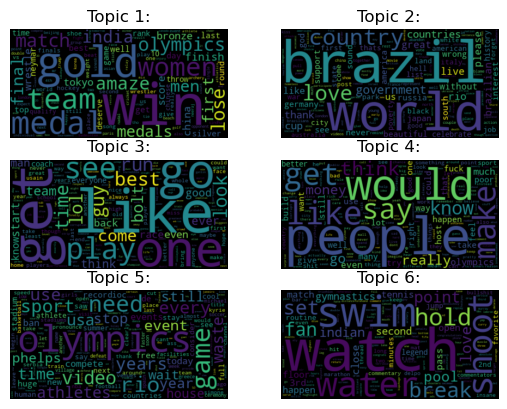

In [33]:
# display wordcloud
displayWordcloud(ldaModel_2016, tfFeatureNames)